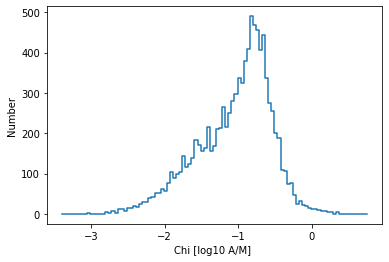

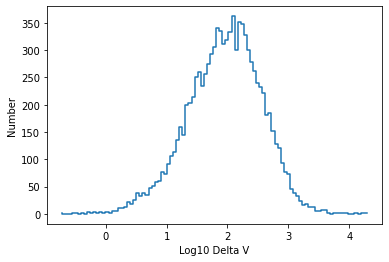

In [1]:
from BreakupModel import *
import numpy as np
import matplotlib.pyplot as plt

L = randL_coll(10000, 1e-1, 1)
x = np.zeros(L.shape)
v = np.zeros(L.shape)
for i in range(len(L)):
    x[i] = randX_coll(1, -4, 4, L[i])
    v[i] = randv_coll(1, -np.inf, np.inf, x[i])

hc,edgesc = np.histogram(x,100)
hv,edgesv = np.histogram(v,100)

import matplotlib.pylab as plt

plt.figure()
plt.step(edgesc[0:-1],hc)
plt.xlabel("Chi [log10 A/M] ")
plt.ylabel("Number")

plt.figure()
plt.step(edgesv[0:-1],hv)
plt.xlabel("Log10 Delta V")
plt.ylabel("Number")

plt.show()